# Seoul Bike Sharing Demand Analysis

**Group 2: Xiao Hu, Vinky Wang, Izzy Zhang**

## 1. Introduction

### 1.1 Motivation

### 1.2 Dataset Description

In [23]:
# Load packages
library(tidyverse)
library(lubridate)
library(corrplot)
library(car)
library(repr)
library(tidymodels)

In [2]:
# Load data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00560/SeoulBikeData.csv"
bike = read.csv(url,check.names=F)

## 2. Methods and Results

### 2.1 Exploratory Data Analysis

#### 2.1.1 Data Cleaning

In [3]:
# Rename columns
colnames(bike) <- c("date", "count", "hour", "temp", "humidity", "windspeed", "visibility", "dew", "solar", "rain", "snow", "seasons", "holiday", "functioning")

# Convert variable into different classes
bike <- bike %>%
  mutate(date = as.POSIXct(date, format = "%d/%m/%Y"), # date
         month =  factor(months(date)),      # add months variable
         seasons = factor(seasons), # factor
         holiday = factor(holiday), # factor
         functioning = factor(functioning)) # factor

We noticed that count becomes zero when `functioning == "No"`. So we proceeded with removing all rows when the bike sharing system is not functioning and the `functioning` column. 

In [4]:
## remove functioning == "No" rows from the dataset. 
bike <- bike[which(bike$functioning == "Yes"),]
bike <- subset(bike, select = -functioning)

We are also removing the `date` column since we do not plan to do time series analysis. 

In [5]:
bike <- subset(bike, select = -date)
head(bike)

,count,hour,temp,humidity,windspeed,visibility,dew,solar,rain,snow,seasons,holiday,month
,<int>,<int>,<dbl>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<fct>
1,254,0,-5.2,37,2.2,2000,-17.6,0,0,0,Winter,No Holiday,December
2,204,1,-5.5,38,0.8,2000,-17.6,0,0,0,Winter,No Holiday,December
3,173,2,-6.0,39,1.0,2000,-17.7,0,0,0,Winter,No Holiday,December
4,107,3,-6.2,40,0.9,2000,-17.6,0,0,0,Winter,No Holiday,December
5,78,4,-6.0,36,2.3,2000,-18.6,0,0,0,Winter,No Holiday,December
6,100,5,-6.4,37,1.5,2000,-18.7,0,0,0,Winter,No Holiday,December


After cleaning the data, we split the dataframe into training and testing for further analyses. We chose a proportion of 70/30. 

In [6]:
bike_split <- initial_split(bike, prop = 0.7)
bike_training <- training(bike_split)
bike_testing <- testing(bike_split)

#### 2.1.2 Multi-collinearity
We have tested for multi-collinearity in the whole dataset in our proposal. Now we will identify variables in the training set that are correlated with one another and select a subset of the dataset that minimizes multicollinearity. 

,temp,humidity,windspeed,visibility,dew,solar,rain,snow
temp,1.00000000,0.1618249,-0.028831056,0.03572386,0.91255382,0.34870996,0.04944487,-0.217531271
humidity,0.16182495,1.0000000,-0.328990037,-0.54320040,0.53839104,-0.46348433,0.23982029,0.097058201
windspeed,-0.02883106,-0.3289900,1.000000000,0.17874336,-0.16735238,0.32980622,-0.01549144,0.003990566
visibility,0.03572386,-0.5432004,0.178743363,1.00000000,-0.17548980,0.15402361,-0.17589158,-0.112981786
dew,0.91255382,0.5383910,-0.167352379,-0.17548980,1.00000000,0.08755331,0.12608226,-0.153318610
solar,0.34870996,-0.4634843,0.329806222,0.15402361,0.08755331,1.00000000,-0.07715863,-0.070950902
rain,0.04944487,0.2398203,-0.015491439,-0.17589158,0.12608226,-0.07715863,1.00000000,-0.002139210
snow,-0.21753127,0.0970582,0.003990566,-0.11298179,-0.15331861,-0.07095090,-0.00213921,1.000000000


Warning message in text.default(pos.xlabel[, 1], pos.xlabel[, 2], newcolnames, srt = tl.srt, :
“"use" is not a graphical parameter”
Warning message in text.default(pos.ylabel[, 1], pos.ylabel[, 2], newrownames, col = tl.col, :
“"use" is not a graphical parameter”
Warning message in title(title, ...):
“"use" is not a graphical parameter”


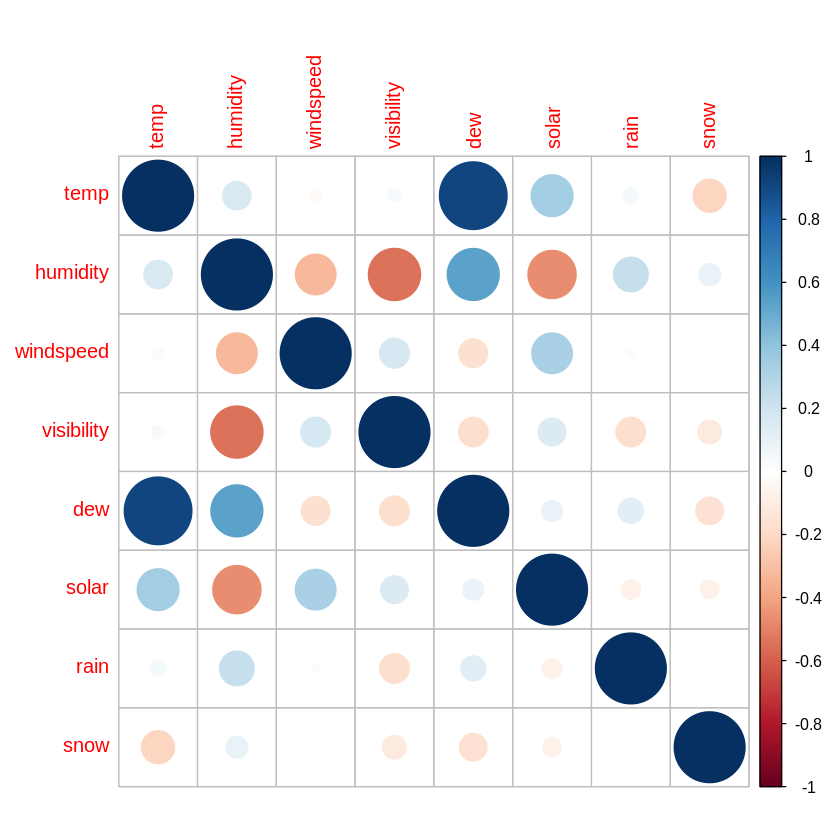

In [11]:
# Select only numeric environmental variables
bike_var <- bike_training %>%
  select(c(temp, humidity, windspeed, visibility, dew, solar, rain, snow))

# Correlation matrix
cor_matrix <- cor(bike_var)
cor_matrix

# Correlation plot
corrplot(cor_matrix, use = "complete.obs", method="circle")

We see from the correlation plot a strong positive correlation between `dew` and `temp`, a relatively strong positive correlation between `dew` and `humidity`, a strong negative correlation between `visibility` and `humidity`, and a relatively strong negative correlation between `solar` and `humidity`. 

We proceed to test the observations above using variance inflation factors (VIF). 

In [12]:
# Variance inflation factor selection with all numerical variables
model_vif1 <- lm(count~ temp + humidity + windspeed + visibility + dew + solar + rain + snow, data = bike_training)
vif(model_vif1)

ERROR: Error in vif(model_vif1): could not find function "vif"


We see that `temp`, `humidity` and `dew` have VIFs larger than 5, suggesting high correlation with other variables. We start by removing `dew`, which has the highest VIF. 

In [ ]:
## remove dew variable
model_vif2 <- lm(count~ temp + humidity + windspeed + visibility  + solar + rain + snow, data = bike)
vif(model_vif2)

All VIFs are now lower than 5. We can then remove `dew` from our testing set and continue with model fitting. 

In [ ]:
bike_training <- subset(bike_training, select = -dew)
bike_training

### 2.2 Model Selection

### 2.3 Model Evaluation

## 3. Discussion

## 4. References